# Project 1 - Regression

<h5 style="font-size: 1.3em;color: #69956e;"> Predict total bikes that will be rented per day</h5>
<p>This notebook uses the <em>bike_day_v2.xlsx</em> file.</p>

<strong>Machine Learning for Marketing 2023/2024</strong>

<strong>Professors:</strong>
- Nuno António
- Ana Edmundo
- Hugo Silva
- Vasco Jesus

<strong>Projet developed by:</strong>
- Anabela Florência, r20201584
- António Cadaixa, r20201505
- Constança Rodrigues, r20201586
- Joana Pimenta, r20201590
- Laura Freitas, 20230172
<br>

<h5 style="font-size: 1.3em;color: #69956e;"> Dataset Description</h5>

- `instant`: Index of the dataset
- `dteday`: Records the specific date
- `season`: Records the season
	- 1: The season is Spring
	- 2: The season is Summer
    - 3: The season is Fall
    - 4: The season is Winter
- `yr`: Records the year (0: 2011, 1:2012)
- `mnth`: Records the month (1 to 12)
- `holiday`: Captures whether the specific is a holiday (0: not a holiday, 1: holiday). This variable was obtained through: http://dchr.dc.gov/page/holiday-schedule)
- `weekday`: Captures the day of the week
	- 0: Sunday
    - 1: Monday
	- 2: Tuesday
    - 3: Wednesday
    - 4: Thursday
    - 5: Friday
    - 6: Saturday
- `workingday`: Indicates whether the day falls on a regular weekday (0: holiday or weekend, 1: regular day)
- `schoolday`: Captures whether a certain day is a school day (0: not a school day, 1: school day)
- `weathersit`: Indicates the specific weather conditions on a certain day
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp`: Represents the normalized temperature in Celsius, with values scaled down to a maximum of 41
- `atemp`: Represents the normalized feeling temperature in Celsius, with values scaled down to a maximum of 50
- `hum`: Represents the normalized humidity, with values scaled down to a maximum of 100
- `windspeed`: Represents the normalized wind speed, with values scaled down to a maximum of 67
- `casual`: Represents the count of casual users
- `registered`: Represents the count of registered users
- `cnt`: Represents the count of total rental bikes, including both casual and registered
<br>

<h5 style="font-size: 1.3em; color: #69956e;">Work Description</h5>

<p style="color: #000000;">This document aims to further explore the needs of a bike rental company that wishes to develop a model for predicting the total number of bikes they will rent each day at 15:00 for the following day.</p>
<p style="color: #000000;">The objective is to optimize resource allocation and enhance the daily marketing budget on social media, their primary form of advertisement.</p>

# Initializations and Data Loading

In [1]:
# Load packages
import os
import datetime
import random
import warnings
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import tree
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import SplineTransformer
from feature_engine.creation import CyclicalFeatures
from yellowbrick.model_selection import RFECV, LearningCurve
from yellowbrick.regressor import ResidualsPlot, PredictionError
from math import sqrt
import category_encoders as ce
import pickle
import graphviz
import statsmodels.api as sm
from numpy.polynomial.polynomial import Polynomial

warnings.filterwarnings('ignore')

# To plot in notebook
%matplotlib inline

In [2]:
# Load the dataset
ds = pd.read_excel('bike_day_v2.xlsx', engine='openpyxl')

# Data Understanding

In [3]:
# Display the top 10 rows - provides an overview of the varibles and facilitates data understanding 
ds.head(10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,schoolday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6.0,0,0.0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0.0,0,0.0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1.0,1,1.0,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2.0,1,1.0,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3.0,1,1.0,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
5,6,2011-01-06,1,0,1,0,4.0,1,1.0,1,0.204348,0.233209,0.518261,0.089565,88,1518,1606
6,7,2011-01-07,1,0,1,0,5.0,1,1.0,2,0.196522,0.208839,0.498696,0.168726,148,1362,1510
7,8,2011-01-08,1,0,1,0,6.0,0,0.0,2,0.165000,0.162254,0.535833,0.266804,68,891,959
8,9,2011-01-09,1,0,1,0,0.0,0,0.0,1,0.138333,0.116175,0.434167,0.361950,54,768,822
9,10,2011-01-10,1,0,1,0,1.0,1,1.0,1,0.150833,0.150888,0.482917,0.223267,41,1280,1321


In [4]:
# More detailed information about the DataFrame and the variables
# Helps understanding the existing types of data and the amount of non-null entries of each variable
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     732 non-null    int64         
 1   dteday      732 non-null    datetime64[ns]
 2   season      732 non-null    int64         
 3   yr          732 non-null    int64         
 4   mnth        732 non-null    int64         
 5   holiday     732 non-null    int64         
 6   weekday     730 non-null    float64       
 7   workingday  732 non-null    int64         
 8   schoolday   454 non-null    float64       
 9   weathersit  732 non-null    int64         
 10  temp        732 non-null    float64       
 11  atemp       732 non-null    float64       
 12  hum         732 non-null    float64       
 13  windspeed   732 non-null    float64       
 14  casual      732 non-null    int64         
 15  registered  732 non-null    int64         
 16  cnt         732 non-null  

### Conclusion
- We have 17 columns and 732 observations
- The variables "schoolday" and "weekday" present some null values. 
- There is a predominance of numerical variables (int64,float64).

In [5]:
# Check on missing values 

# Count of missing values per column
print(ds.isnull().sum())

# Percentage of each column's data missing
round(ds.isna().sum()/ds.shape[0]*100,2)

# Conclusion: only 'weekday' and 'schoolday' variables have missing values

instant         0
dteday          0
season          0
yr              0
mnth            0
holiday         0
weekday         2
workingday      0
schoolday     278
weathersit      0
temp            0
atemp           0
hum             0
windspeed       0
casual          0
registered      0
cnt             0
dtype: int64


instant        0.00
dteday         0.00
season         0.00
yr             0.00
mnth           0.00
holiday        0.00
weekday        0.27
workingday     0.00
schoolday     37.98
weathersit     0.00
temp           0.00
atemp          0.00
hum            0.00
windspeed      0.00
casual         0.00
registered     0.00
cnt            0.00
dtype: float64

##  Summary statistics analysis

In [6]:
# Summary statistics for all variables to better understand them and check if there's any inconsistencies 
ds.describe(include='all').T

,count,mean,min,25%,50%,75%,max,std
instant,732.0,366.352459,1.0,183.75,366.5,549.25,731.0,211.236679
dteday,732,2012-01-01 08:27:32.459016448,2011-01-01 00:00:00,2011-07-02 18:00:00,2012-01-01 12:00:00,2012-07-02 06:00:00,2012-12-31 00:00:00,NaN
season,732.0,2.497268,1.0,2.0,3.0,3.0,4.0,1.110203
yr,732.0,0.501366,0.0,0.0,1.0,1.0,1.0,0.50034
mnth,732.0,6.523224,1.0,4.0,7.0,10.0,12.0,3.450769
holiday,732.0,0.028689,0.0,0.0,0.0,0.0,1.0,0.167044
weekday,730.0,3.00274,0.0,1.0,3.0,5.0,6.0,2.004793
workingday,732.0,0.68306,0.0,0.0,1.0,1.0,1.0,0.465602
schoolday,454.0,0.460352,0.0,0.0,0.0,1.0,1.0,0.498975
weathersit,732.0,1.394809,1.0,1.0,1.0,2.0,3.0,0.544718


#### Completeness of Dataset
Most variables in the dataset are complete, with 732 entries each, indicating no missing values. However, `schoolday` has only 454 non-null entries, which means there are 278 missing values (approximately 38% of the data for that variable). The variable `weekday` has 2 missing values as well.

#### Variable Analysis
- `instant`: Integer variable that represents the index.  It contains 732 entries. It's statistical measures, such as mean and median are not informative for the dataset's analysis.

- `dteday`: Datetime variable that goes from 01-01-2011 until 31-12-2012 (2 years).
 
- `season`: Integer variable indicating the season (from 1 to 4 ). The mean is around 2.5, suggesting a fairly even distribution across the seasons. Looking at the percentiles, the 25th percentile is 2 (summer) and the 75th percentile is 3 (fall),  implying that the majority of the observations fall within these warmer seasons, with fall being the most common season based on the median value.

- `yr`: Integer variable that takes the values 0 and 1, representing the years under study (0 being 2011 and 1 being 2012).

- `mnth`: Integer variable representing the months of the year, ranging from 1 to 12.

- `holiday`: Integer variable indicating whether the day is a holiday or not. It's mostly 0, as expected, since holidays are relatively rare. 

- `weekday`: Float variable representing weekdays, ranging from 0 to 6, with 0 representing Sunday and 6 representing Saturday. It  has 2 missing values.

- `workingday`: Integer variable representing working days, ranging from 0 (non-working day) to 1 (working day). The mean value of approximately 0.683 suggests that working days are more prevalent in the dataset, as expected.

- `schoolday`: Float variable, with missing values, as stated before. The mean close to 0.5 (~0.46) for existing data, suggests an almost equal split between days that are school days and those that are not.

- `weathersit`: Integer variable indicating the weather situation  (going from 1 to 4 representing different weather conditions). The mean suggests that most days have a weather situation of 1 (~1.39) , which correspond to clear conditions.

- `temp`: Float variable that represents the normalized temperature, with a mean around 0.5. The range of the values is from about 0.06 to 0.86, which indicates a wide variety of temperatures.

- `atemp`: Float variable that represents the feeling temperature, very similar to the 'temp' variable, indicating a high correlation.

- `hum`: Float variable that represents the normalized humidity, with values ranging from 0 to 0.97 and a mean around 0.63, indicating a considerable spredy of humidity condition throughout the dataseted.

- `windspeed`: Float variable representing normalized wind speed, with a significant range of values, from about 0.02 to 10.23, and a mean of 0.20. The max value is quite high compared to the 75th percentile and the standard deviation values are a bit high as well, which may indicate an outlier or extreme wind conditions.

- `casual`: Integer variable that represents the number of casual users. It shows high variability, evident from the large standard deviation value.

- `registered`: Integer variable representing the number of registered users. It consistently shows higher values compared to casual users which indicates that there are more registered users renting bikes. Similar the previous variable, this one also demonstrates significant variability.

- `cnt`: Integer variable that represents the total count of bike rentals, which is the target variable for prediction. It shows substantial day-to-day variations, with values ranging from 22 to 8714 and a standard deviation of almost 1950. These values suggest significant fluctuations in daily rental activity, with days with very few rentals and others with very high usage. It is calculated by the sum of 'casual' and 'registered'.

### Final Considerations
The weather-related variables (`temp`, `atemp`, `hum`, `windspeed`) are normalized, with `temp` and `atemp` closely correlated. The `windspeed` variable might contain outliers, as the maximum value is far from the 75th percentile.

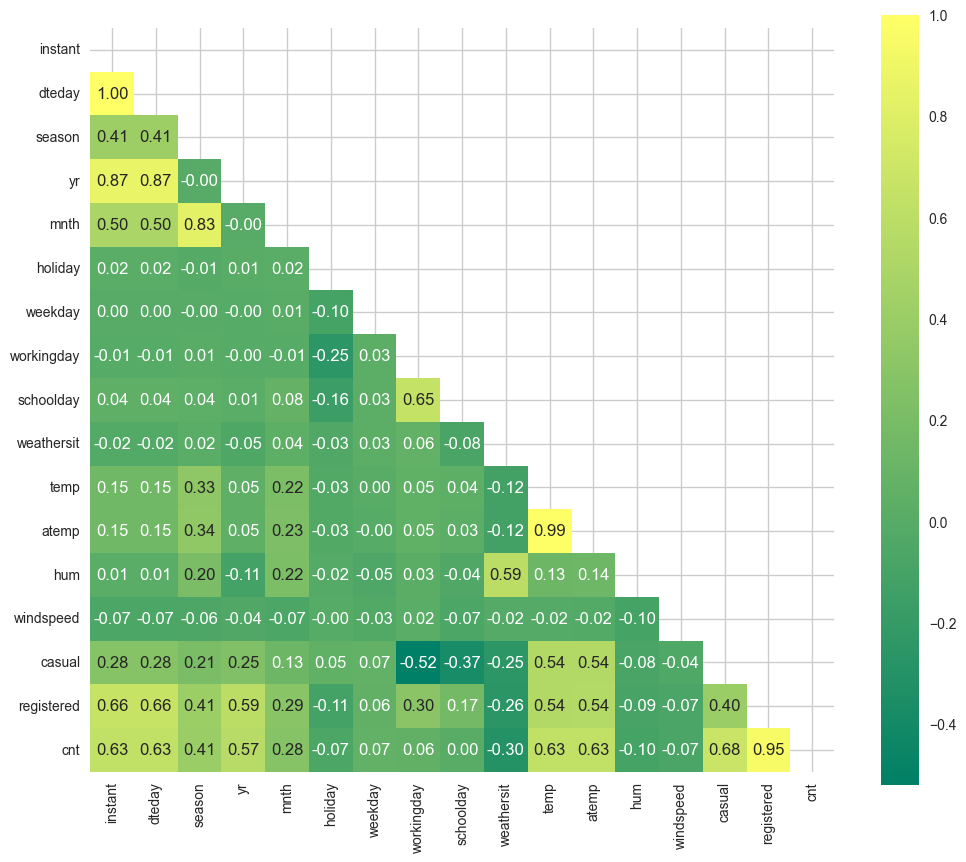

In [7]:
# Visualize the correlation matrix as a heatmap to easily identify relationships between variables

correlation_matrix = ds.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", mask=mask, cmap="summer", cbar=True, square=True)

plt.show()

## Correlation Matrix Heatmap Analysis

1. **Temperature Factors**: There is an extremely high positive correlation between `temp` (temperature) and `atemp` (feeling temperature), which suggests similar information between them. Given this redundacy, one of these variables may be dropped to avoid multicollinearity. `temp` has also significant values of correlation with `cnt` which may indicate that is a good variable to predict our target variable.

2. **Seasonality and Rentals**: The season (`season`) and month (`mnth`) variables show a strong relationship, which is logical, and both have a moderate correlation with the total rentals (`cnt`), suggesting that the time of the year is a relevant factor in the number of rented bikes.

3. **User Types and Rentals**: The number of registered users (`registered`) is highly positively correlated with the total count of bike rentals (`cnt`). This suggests that registered users are a are a predominance on the total of rented bikes.

4. **Types of Days**: `workingday` and `schoolday` variables also show a high positive correlation, which makes sense since both variables similarly characterize the standard work week, excluding weekends and holidays. As said on the previous observation, one of these variables may be dropped to avoid multicollinearity.

5. Some variables like `holiday`, `weekday`, and `workingday` appear to have less of an impact on bike rentals, as indicated by their lower correlation coefficients with the total rentals (`cnt`).

# Data Visualization

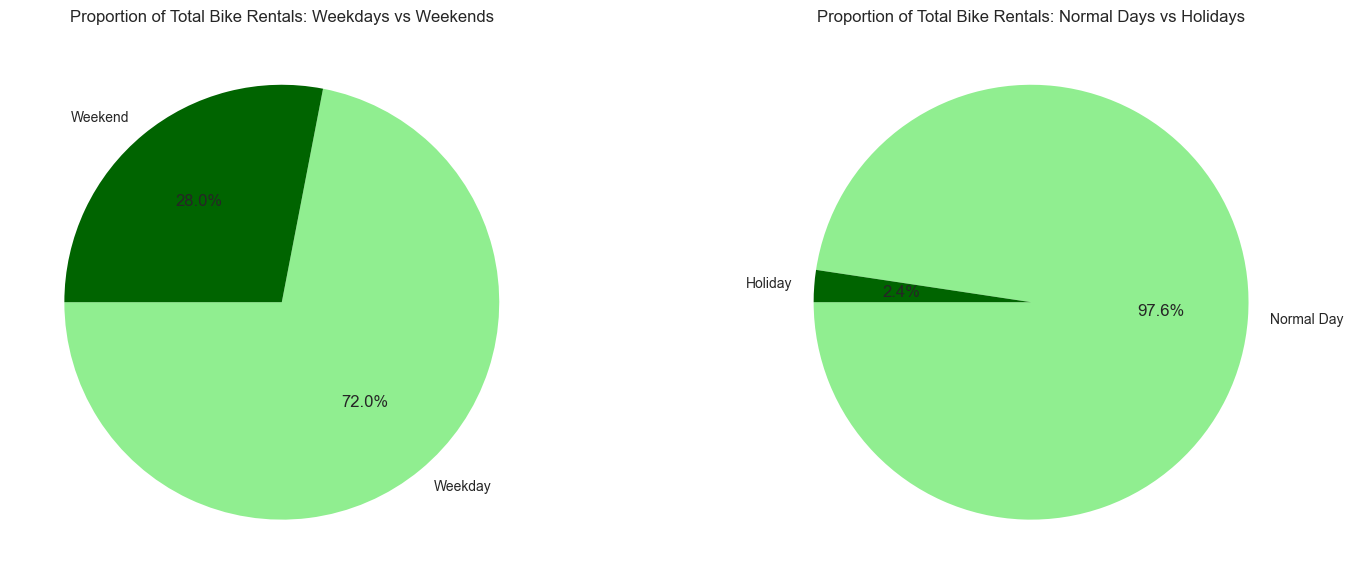

In [8]:
# Pie Plots: Weekdays vs. Weekends and Normal Days vs. Holidays

# Calculate the total rentals for weekdays vs weekends
ds['day_type'] = ds['weekday'].apply(lambda x: 'Weekend' if x == 0 or x == 6 else 'Weekday')
total_rentals_day_type = ds.groupby('day_type')['cnt'].sum()

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart for Weekdays vs Weekends
axs[0].pie(total_rentals_day_type, labels=total_rentals_day_type.index, autopct='%1.1f%%', startangle=180, colors=['lightgreen','darkgreen'])
axs[0].set_title('Proportion of Total Bike Rentals: Weekdays vs Weekends')

# Calculate the total rentals for normal days vs holidays
total_rentals_holiday = ds.groupby('holiday')['cnt'].sum()
total_rentals_holiday.index = ['Normal Day', 'Holiday']

# Pie chart for Normal Days vs Holidays
axs[1].pie(total_rentals_holiday, labels=total_rentals_holiday.index, autopct='%1.1f%%', startangle=180, colors=['lightgreen','darkgreen'])
axs[1].set_title('Proportion of Total Bike Rentals: Normal Days vs Holidays')

plt.tight_layout()
plt.show()

### Conclusion
- Weekdays account for the majority of bike rentals (72%), indicating higher usage during the typical workweek.
- Normal days constitute the vast majority of bike rentals (97.6%), indicating predominant usage on regular, non-holiday occasions. 

In [9]:
# Remove the column 'day_type' since we won't use it anymore
ds = ds.drop(columns=['day_type'])

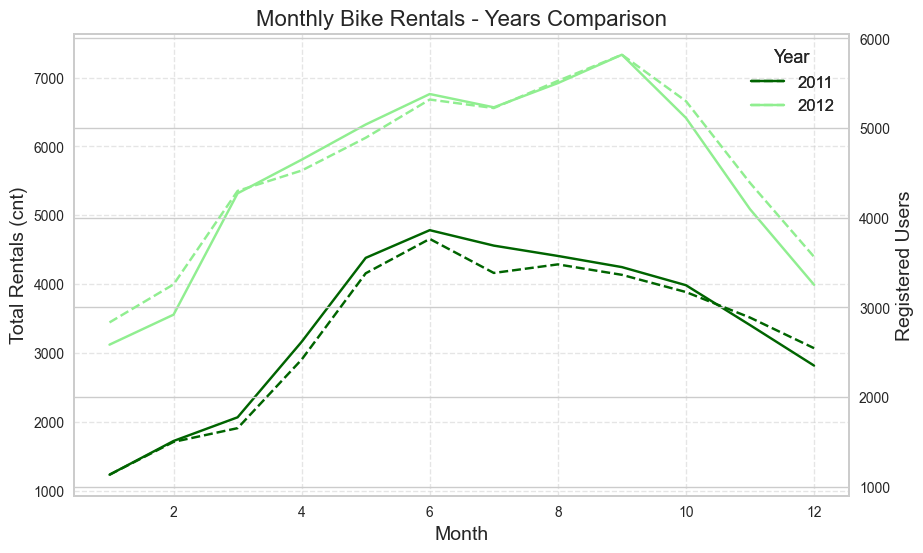

In [10]:
# Line Plot of 'cnt' and 'registered' Over Time:

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(x='mnth', y='cnt', hue='yr', data=ds, palette={0: 'darkgreen', 1: 'lightgreen'}, ax=ax1, errorbar=None)
ax1.set_title('Monthly Bike Rentals - Years Comparison', fontsize=16)
ax1.set_xlabel('Month', fontsize=14)
ax1.set_ylabel('Total Rentals (cnt)', fontsize=14)
ax1.legend(title='Year', title_fontsize='13', fontsize='12')
ax1.grid(True, linestyle='--', alpha=0.5)
ax2 = ax1.twinx()
sns.lineplot(x='mnth', y='registered', hue='yr', data=ds, palette={0: 'darkgreen', 1: 'lightgreen'}, ax=ax2, linestyle='--', errorbar=None)
ax2.set_ylabel('Registered Users', fontsize=14)
ax2.legend(title='Year', title_fontsize='13', fontsize='12', loc='upper right')


# Transforming legend labels
legend_labels = {0: '2011', 1: '2012'}
for ax in [ax1, ax2]:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=[legend_labels[int(label)] for label in labels], title='Year', title_fontsize='13', fontsize='12')

plt.show()

### Conclusion
- In the plot, the solid line represents the total bike rentals (`cnt`) over time, showing the trend of rentals throughout the months for each year. 
- It's evident that during the middle months of the year, there are more bike rentals, indicating potential seasonal trends.
- The dashed line represents the number of rentals made by registered users (`registered`).
- Additionally, there's a noticeable improvement in bike rentals from 2011 to 2012.
- We might assume that in the following year, bike rentals should continue to improve.
- The shaded area between the solid and dashed lines represents the overlap or difference between total rentals and rentals by registered users, showcasing the contribution of casual users to the total rentals over time.

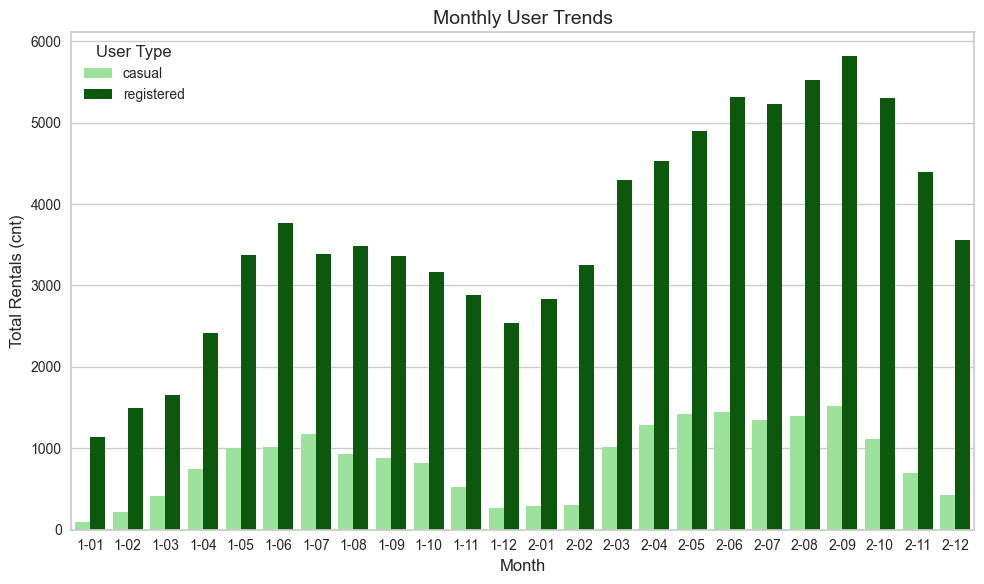

In [11]:
# Bar Plots for Monthly User Trends - reveal similar insights to the previous line plot

# Melt the DataFrame to long format
ds_melted = ds.melt(value_vars=['casual', 'registered'], var_name='User Type', value_name='Count', id_vars=['yr', 'mnth'])

# Convert 'mnth' to a format that combines 'yr' and 'mnth' for a continuous timeline across years
# This assumes 'yr' starts from 0 for the first year in the dataset, adjust accordingly if different
ds_melted['Year-Month'] = ds_melted.apply(lambda row: f"{row['yr']+1}-{row['mnth']:02d}", axis=1)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Year-Month', 
    y='Count', 
    hue='User Type', 
    data=ds_melted, 
    palette=['lightgreen', 'darkgreen'],  # Custom colors for casual and registered
    ci=None  # Remove the error bars
)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Rentals (cnt)', fontsize=12)
plt.title('Monthly User Trends', fontsize=14)

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

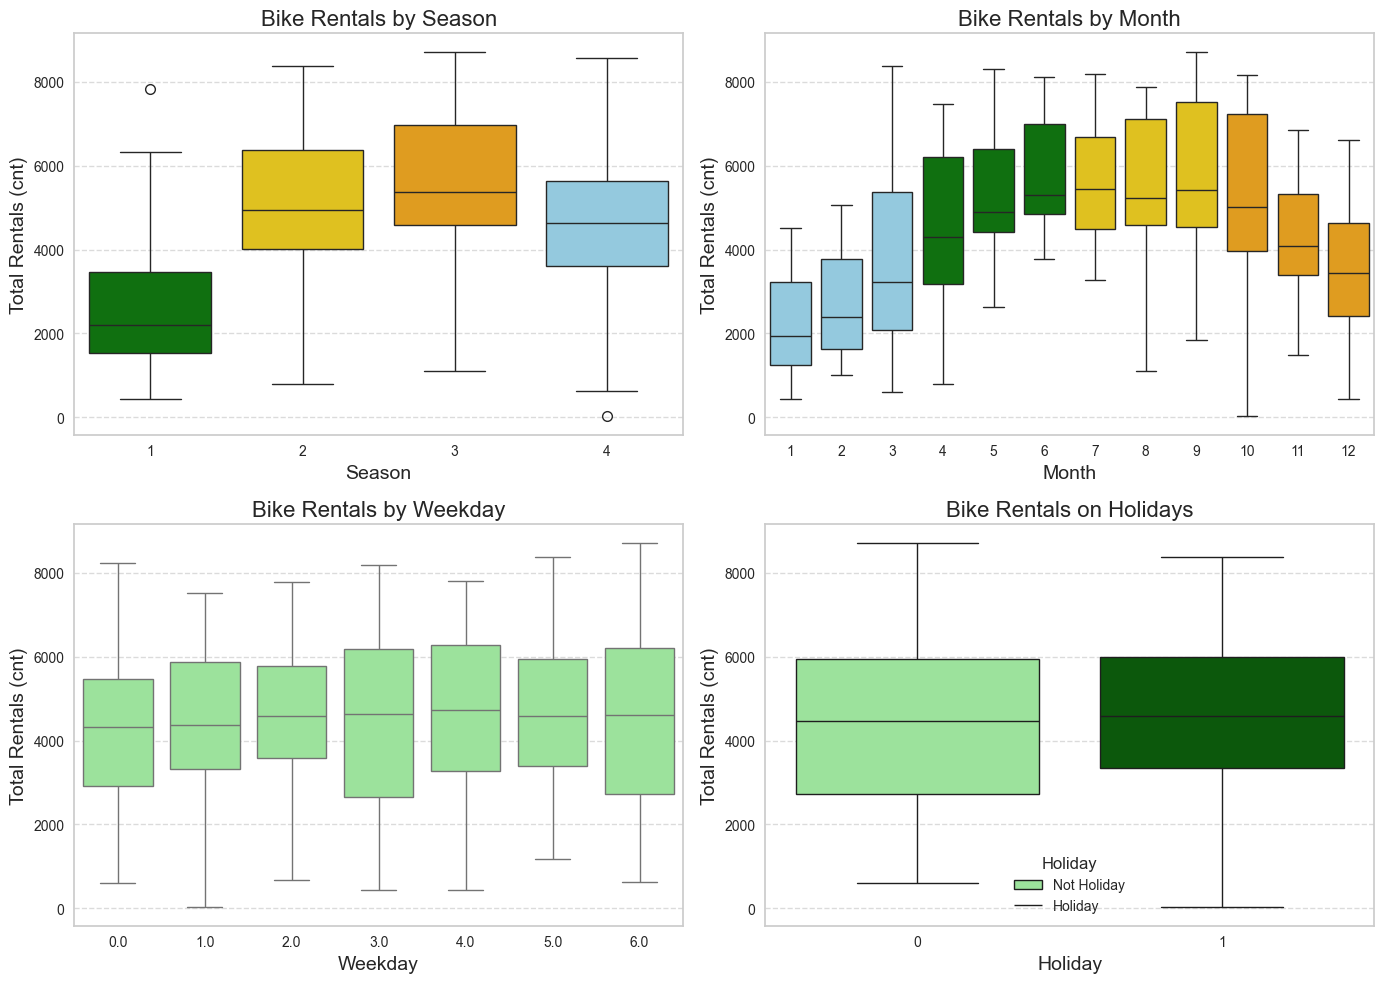

In [12]:
# Box Plots for Rentals by Season, Month, Weekday and Holiday - Categorical Variables

# Define color mappings
season_colors = {'1': 'green', '2': 'gold', '3': 'orange', '4': 'skyblue'}
month_colors = {'1': 'skyblue', '2': 'skyblue', '3': 'skyblue', '4': 'green', '5': 'green', '6': 'green', '7': 'gold', '8': 'gold', '9': 'gold', '10': 'orange', '11': 'orange', '12': 'orange'}
holiday_palette = {0: 'lightgreen', 1: 'darkgreen'}

# Set figure size
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='season', y='cnt', data=ds, palette=season_colors)
plt.title('Bike Rentals by Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Total Rentals (cnt)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 2, 2)
sns.boxplot(x='mnth', y='cnt', data=ds, palette=month_colors)
plt.title('Bike Rentals by Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Rentals (cnt)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 2, 3)
sns.boxplot(x='weekday', y='cnt', data=ds, color='lightgreen')  # Using lightgreen for weekdays
plt.title('Bike Rentals by Weekday', fontsize=16)
plt.xlabel('Weekday', fontsize=14)
plt.ylabel('Total Rentals (cnt)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 2, 4)
sns.boxplot(x='workingday', y='cnt', data=ds, palette=holiday_palette, hue='workingday')
plt.title('Bike Rentals on Holidays', fontsize=16)
plt.xlabel('Holiday', fontsize=14)
plt.ylabel('Total Rentals (cnt)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Holiday', labels=['Not Holiday', 'Holiday'])

# Improve subplot spacing
plt.tight_layout()

plt.show()

### Conclusion
- There is a noticeable variation in bike rentals across different seasons. The highest rentals are observed in summer (Season 2  - gold) and fall (Season 3 - orange), while the lowest rentals are in spring (Season 1 - green).
- The pattern of rentals by month aligns with the seasons, with higher rentals during warmer months and lower rentals during colder months.
- There seems to be some variation in rentals based on the day of the week.

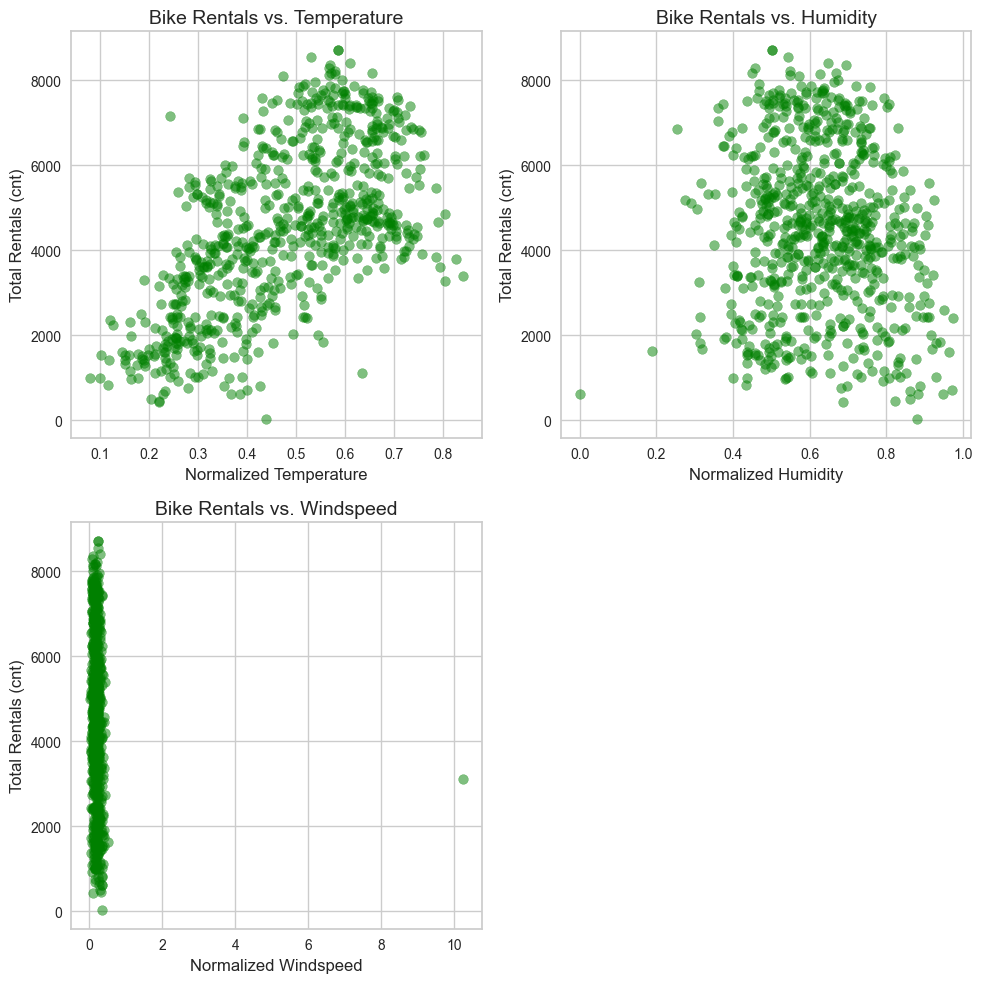

In [13]:
# Scatter Plots of Rentals against Weather Conditions

fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Adjust figsize as needed

# Scatter Plot for Bike Rentals vs. Temperature
axs[0, 0].scatter(ds['atemp'], ds['cnt'], alpha=0.5, color='green')
axs[0, 0].set_title('Bike Rentals vs. Temperature', fontsize=14)
axs[0, 0].set_xlabel('Normalized Temperature', fontsize=12)
axs[0, 0].set_ylabel('Total Rentals (cnt)', fontsize=12)

# Scatter Plot for Bike Rentals vs. Humidity
axs[0, 1].scatter(ds['hum'], ds['cnt'], alpha=0.5, color='green')
axs[0, 1].set_title('Bike Rentals vs. Humidity', fontsize=14)
axs[0, 1].set_xlabel('Normalized Humidity', fontsize=12)
axs[0, 1].set_ylabel('Total Rentals (cnt)', fontsize=12)

# Scatter Plot for Bike Rentals vs. Windspeed
axs[1, 0].scatter(ds['windspeed'], ds['cnt'], alpha=0.5, color='green')
axs[1, 0].set_title('Bike Rentals vs. Windspeed', fontsize=14)
axs[1, 0].set_xlabel('Normalized Windspeed', fontsize=12)
axs[1, 0].set_ylabel('Total Rentals (cnt)', fontsize=12)

# Remove empty subplot
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Check 'windspeed' distribution, since the max value is far from 75th percentile, suggesting outliers or skewness, as seen on the previous graph
# Mode, median, and mean can indicate the distribution's shape and central tendency

mode_windspeed = ds['windspeed'].mode()[0]
median_windspeed = ds['windspeed'].median()
mean_windspeed = ds['windspeed'].mean()

print("Mode of windspeed:", mode_windspeed)
print("Median of windspeed:", median_windspeed)
print("Mean of windspeed:", mean_windspeed)

Mode of windspeed: 0.10635
Median of windspeed: 0.180975
Mean of windspeed: 0.20401858565573772


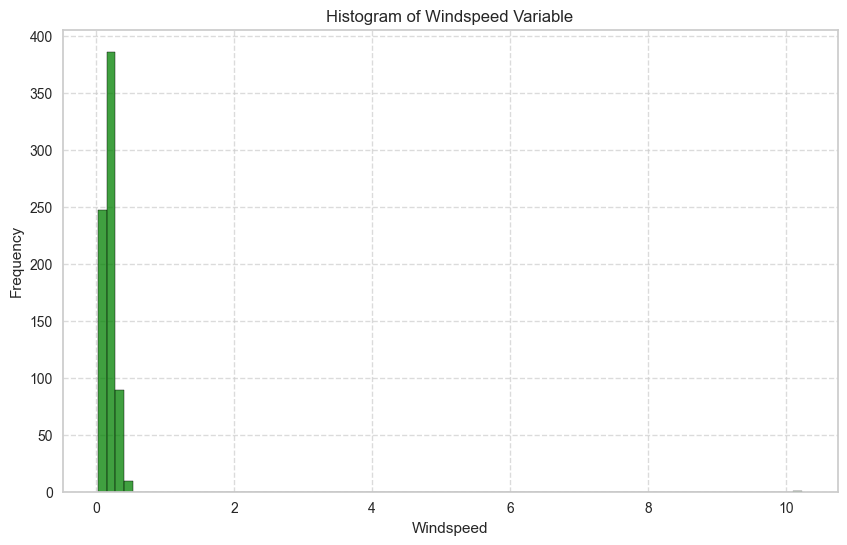

In [15]:
# Create a histogram of 'windspeed' variable

plt.figure(figsize=(10, 6))
sns.histplot(ds['windspeed'], bins=80, color='green', edgecolor='black', kde=False)
plt.xlabel('Windspeed')
plt.ylabel('Frequency')
plt.title('Histogram of Windspeed Variable')
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid for better readability

plt.show()

### Conclusion
- The 'windspeed' data exhibits a right-skewed distribution, evident from the higher maximum value (10.23) compared to the central tendency measures (median: 0.18 and mean: 0.20).
- This deviation from normality suggests that the Interquartile Range (IQR) method is appropriate for outlier detection since it relies on the median and quartiles
- However, considering the existence of just one severe outlier as seen on the previous graph and next graph, we opted for another method

In [16]:
# Calculate the IQR for 'windspeed'
Q1 = ds['windspeed'].quantile(0.25)
Q3 = ds['windspeed'].quantile(0.75)
IQR = Q3 - Q1

# Determine the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_bound, upper_bound

(-0.01268937500000003, 0.381015625)

In [17]:
# Identify the number of outliers
outliers = ds[(ds['windspeed'] < lower_bound) | (ds['windspeed'] > upper_bound)]
len(outliers)

13

In [18]:
# Find the severe outlier on the 99th percentile value of 'windspeed' to minimize its outlier influence, creating a 'windspeed_capped' column for further analysis
windspeed_99th_percentile = ds['windspeed'].quantile(0.99)
print(windspeed_99th_percentile)

ds['windspeed_capped'] = ds['windspeed'].apply(lambda x: min(x, windspeed_99th_percentile))

0.4130677199999997


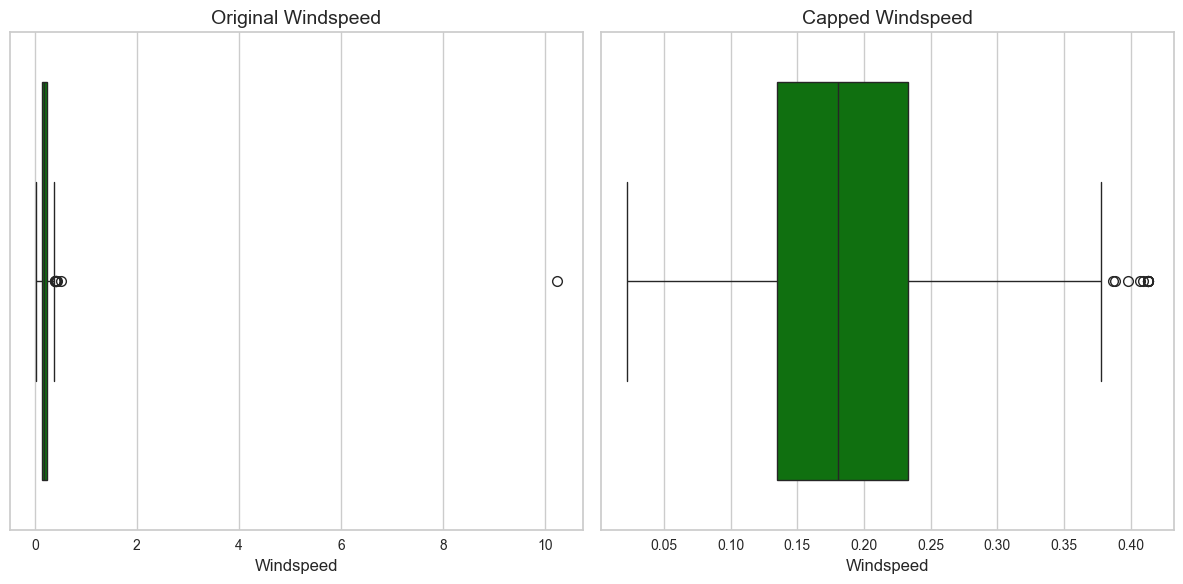

In [19]:
# The capping process replaces any 'windspeed' values above the 99th percentile with the 99th percentile value itself, thereby constraining extreme values and stabilizing the distribution.

# Plot original and capped 'windspeed' distributions
plt.figure(figsize=(12, 6))

# Plot the original 'windspeed' distribution
plt.subplot(1, 2, 1)
sns.boxplot(x=ds['windspeed'], orient='h', color='green')
plt.title('Original Windspeed', fontsize=14)
plt.xlabel('Windspeed', fontsize=12)

# Plot the capped 'windspeed' distribution for comparison
plt.subplot(1, 2, 2)
sns.boxplot(x=ds['windspeed_capped'], orient='h', color='green')
plt.title('Capped Windspeed', fontsize=14)
plt.xlabel('Windspeed', fontsize=12)

plt.tight_layout()
plt.show()

### Conclusion
- The second boxplot shows a tighter distribution with fewer outliers, indicating a more stable representation of the data data.

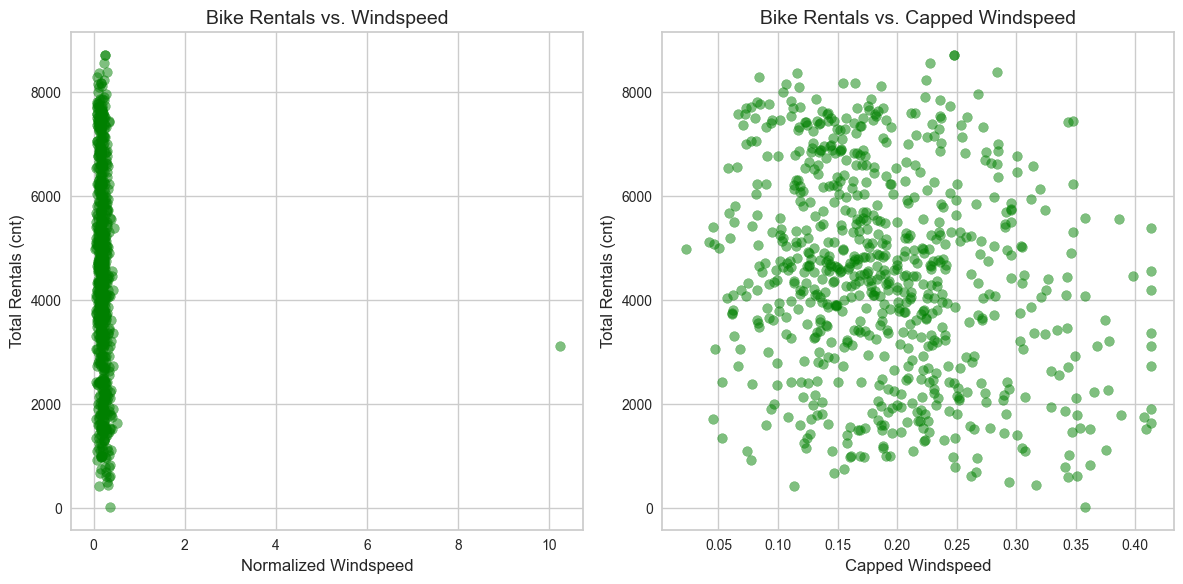

In [20]:
# Scatter Plots of Rentals against windspeed

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create 1 row, 2 columns of subplots

# Scatter Plot for Bike Rentals vs. Windspeed
axs[0].scatter(ds['windspeed'], ds['cnt'], alpha=0.5, color='green')
axs[0].set_title('Bike Rentals vs. Windspeed', fontsize=14)
axs[0].set_xlabel('Normalized Windspeed', fontsize=12)
axs[0].set_ylabel('Total Rentals (cnt)', fontsize=12)

# Scatter Plot for Bike Rentals vs. Capped Windspeed
axs[1].scatter(ds['windspeed_capped'], ds['cnt'], alpha=0.5, color='green')
axs[1].set_title('Bike Rentals vs. Capped Windspeed', fontsize=14)
axs[1].set_xlabel('Capped Windspeed', fontsize=12)
axs[1].set_ylabel('Total Rentals (cnt)', fontsize=12)

plt.tight_layout()
plt.show()

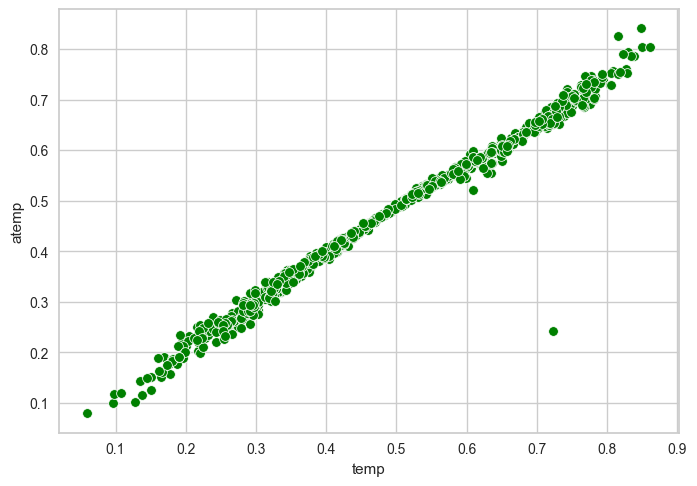

In [21]:
# Analyzing Correlation between 'temp' and 'atemp'

ax = sns.scatterplot(x="temp", y="atemp", data=ds, color='green')
plt.show()

In [22]:
# Based on the previous visual, we'll identify and examine data points where 'temp' and 'atemp' fall within specific ranges, to see which one is not having a normal behavior

temp_mask = (ds['temp'] > 0.6) & (ds['temp'] < 0.9)
atemp_mask = (ds['atemp'] > 0.15) & (ds['atemp'] < 0.3)
anomalous_ds = ds[temp_mask & atemp_mask]
anomalous_ds

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,schoolday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,windspeed_capped
594,595,2012-08-17,3,1,8,0,5.0,1,1.0,1,0.723333,0.2424,0.570833,0.231354,1483,5665,7148,0.231354


# Data Preparation

In [23]:
# Create a copy of the original dataset to ensure that all subsequent changes are made on the duplicated dataset
X = ds.copy(deep=True)

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   instant           732 non-null    int64         
 1   dteday            732 non-null    datetime64[ns]
 2   season            732 non-null    int64         
 3   yr                732 non-null    int64         
 4   mnth              732 non-null    int64         
 5   holiday           732 non-null    int64         
 6   weekday           730 non-null    float64       
 7   workingday        732 non-null    int64         
 8   schoolday         454 non-null    float64       
 9   weathersit        732 non-null    int64         
 10  temp              732 non-null    float64       
 11  atemp             732 non-null    float64       
 12  hum               732 non-null    float64       
 13  windspeed         732 non-null    float64       
 14  casual            732 non-

In [25]:
# Drop the 'dteday' column since we already have seperate columns for 'yr' & 'month' and we believe that the day by itself doesn't represent anything relevant to the analysis.
X = X.drop(columns=['dteday'])

In [26]:
# Remove the 'instant' column since it only represents an index value
X = X.drop(columns=['instant'])

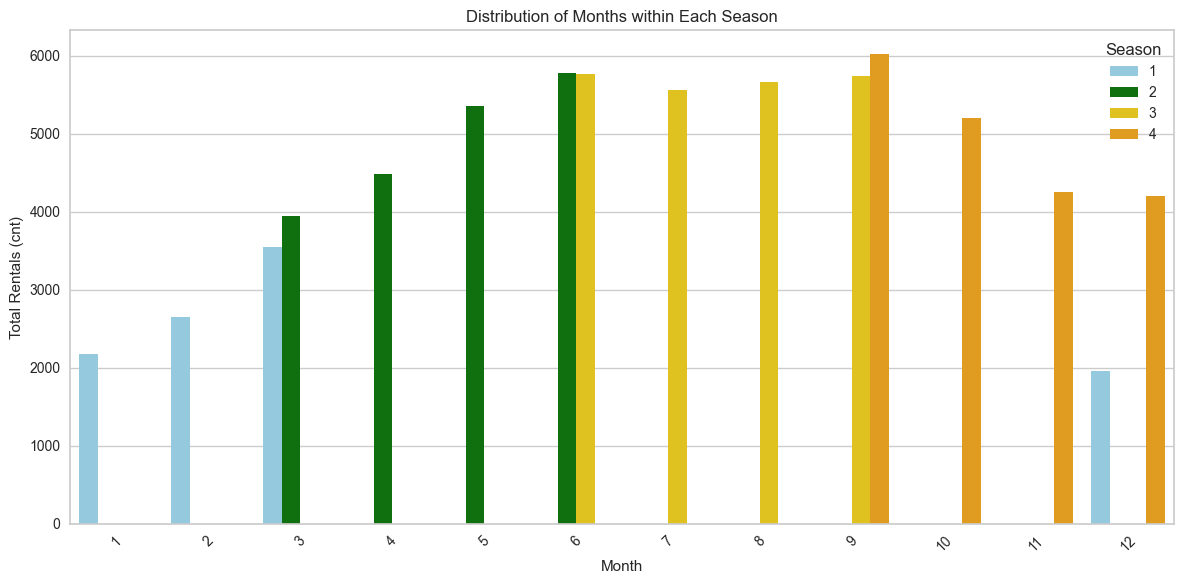

In [27]:
# Create a bar plot to analyze the relationship between 'month' and 'season', considering the correlation observed in the matrix analysis

custom_palette = ['skyblue', 'green', 'gold', 'orange']

plt.figure(figsize=(12, 6))
sns.barplot(x='mnth', y='cnt', hue='season', data=X, palette=custom_palette, ci=None, linewidth=0)
plt.title('Distribution of Months within Each Season')
plt.xlabel('Month')
plt.ylabel('Total Rentals (cnt)')
plt.legend(title='Season')
plt.xticks(ticks=range(12), rotation=45, ha='center')
plt.tight_layout()

plt.show()

# Conclusion:
# It's observed that in majority of cases, the month is strongly related to a specific season.
# However, we decided not to drop the 'season' variable to perform the Linear Regression Analysis since, after performing multiple tests, we understood it was essential to get better results.

## Handling Missing Values

In [28]:
# Create a function to fill the missing values founded earlier of the variable 'schoolday', based on variables 'weekday' and 'holiday'

def fill_schoolday(row):
    # Check if 'schoolday' is missing
    if pd.isnull(row['schoolday']):
        # The conditions for non-school day (weekend and/or holiday) are as follows: (Saturday (row['weekday'] == 6) or Sunday (row['weekday'] == 0)) or holidays (row['holiday'] == 1)
        if row['weekday'] == 6 or row['weekday'] == 0 or row['holiday'] == 1:
            # So, if it happens we assume that these are not school days, hence returns 0
            return 0
        # If none of the above conditions are met, the default value is 1 (a school day)
        else:
            return 1 
    else:
        # If 'schoolday' is not missing, it simply returns the existing value
        return row['schoolday']

# Apply the function to each row
X['schoolday'] = X.apply(fill_schoolday, axis=1)

# Change the 'schoolday' values data type to integer
X['schoolday'] = X['schoolday'].astype(int)

In [29]:
# Create a function to fill the missing values founded earlier of the variable 'weekday'

# Find missing values indices
missing_indices = X[X['weekday'].isna()].index

# Iterate over missing indices
for index in missing_indices:
    print(f"Processing missing value at index {index}:")
    # Get the index of the previous non-missing value
    prev_index = X.loc[:index, 'weekday'].dropna().index[-1]
    print(f"  Previous non-missing value at index {prev_index}: {X.at[prev_index, 'weekday']}")
    # Get the index of the following non-missing value
    next_index = X.loc[index:, 'weekday'].dropna().index[0]
    print(f"  Following non-missing value at index {next_index}: {X.at[next_index, 'weekday']}")
    # Check if previous value is 6 (Friday) and next value is 1 (Monday)
    if X.at[prev_index, 'weekday'] == 6.0 and X.at[next_index, 'weekday'] == 1.0:
        new_value = 0  # Sunday
    else:
        new_value = (X.at[prev_index, 'weekday'] + X.at[next_index, 'weekday']) / 2
    print(f"  Filling missing value with the new value: {new_value}")
    X.at[index, 'weekday'] = new_value

# Check unique values of "weekday" column again to verify
print('Unique values of weekday after filling missing values:', X['weekday'].unique())

Processing missing value at index 190:
  Previous non-missing value at index 189: 6.0
  Following non-missing value at index 191: 1.0
  Filling missing value with the new value: 0
Processing missing value at index 195:
  Previous non-missing value at index 194: 4.0
  Following non-missing value at index 196: 6.0
  Filling missing value with the new value: 5.0
Unique values of weekday after filling missing values: [6. 0. 1. 2. 3. 4. 5.]


In [30]:
# Confirm if all missing values of the variable 'schoolday' and 'weekday' were filled
round(X.isna().sum()/X.shape[0]*100,2)

season              0.0
yr                  0.0
mnth                0.0
holiday             0.0
weekday             0.0
workingday          0.0
schoolday           0.0
weathersit          0.0
temp                0.0
atemp               0.0
hum                 0.0
windspeed           0.0
casual              0.0
registered          0.0
cnt                 0.0
windspeed_capped    0.0
dtype: float64

## Treating Feature Correlation

In [31]:
# Remove the column 'windspeed' since we have the capped version
X = X.drop(columns=['windspeed'])

In [32]:
# Drop the 'atemp' variable due to high correlation with 'temp', observed errors, and inferior modeling performance
X = X.drop(columns=['atemp'])

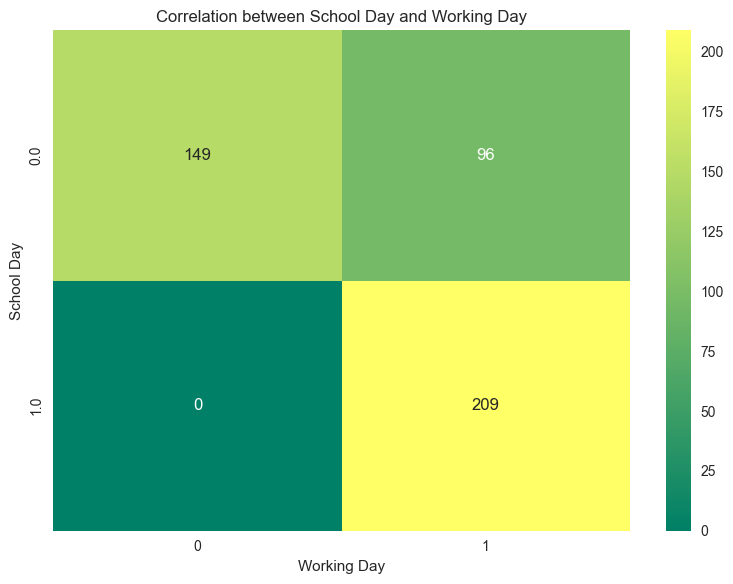

In [33]:
# Create a cross-tabulation of 'schoolday' and 'workinday' to see the correlation between both, given that we now have all the dataset complete

cross_tab = pd.crosstab(ds['schoolday'], ds['workingday'])

plt.figure(figsize=(8, 6))
sns.heatmap(cross_tab, annot=True, cmap='summer', fmt='d')
plt.title('Correlation between School Day and Working Day')
plt.xlabel('Working Day')
plt.ylabel('School Day')

plt.tight_layout()
plt.show()

In [34]:
# In light of the heatmap analysis indicating a correlation between the variables, we have opted to drop the 'scchoolday' 
# Majority of the time, when it's a working day, it's also a school day, leading to inferior modeling performance
X = X.drop(columns=['schoolday'])

In [35]:
# Create a new DataFrame to confirm that 'cnt' is the sum of 'casual' and 'registered' bike rentals

sum_table = pd.DataFrame({
    'casual': X['casual'],
    'registered': X['registered'],
    'sum': X['casual'] + X['registered'],
    'cnt': X['cnt']
})
print(sum_table)

# Check if there are any differences between 'sum' and 'cnt'
sum_table['difference'] = sum_table['sum'] - sum_table['cnt']

# Display rows where there are differences
differences = sum_table[sum_table['difference'] != 0]
print("Rows where there are differences between 'sum' and 'cnt':")
print(differences)

     casual  registered   sum   cnt
0       331         654   985   985
1       131         670   801   801
2       120        1229  1349  1349
3       108        1454  1562  1562
4        82        1518  1600  1600
..      ...         ...   ...   ...
727     247        1867  2114  2114
728     644        2451  3095  3095
729     159        1182  1341  1341
730     364        1432  1796  1796
731     439        2290  2729  2729

[732 rows x 4 columns]
Rows where there are differences between 'sum' and 'cnt':
Empty DataFrame
Columns: [casual, registered, sum, cnt, difference]
Index: []


In [36]:
# Since we observed no differences, we opted to drop the `casual` and `registered` columns from further analysis
# Both these columns contain the count of bike booked by different categories of customers
# Since our goal is to find the total count of bikes and not by specific category
# Also we would not have this variables available in a ´real-world´ situation
X = X.drop(columns=['casual', 'registered'])

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season            732 non-null    int64  
 1   yr                732 non-null    int64  
 2   mnth              732 non-null    int64  
 3   holiday           732 non-null    int64  
 4   weekday           732 non-null    float64
 5   workingday        732 non-null    int64  
 6   weathersit        732 non-null    int64  
 7   temp              732 non-null    float64
 8   hum               732 non-null    float64
 9   cnt               732 non-null    int64  
 10  windspeed_capped  732 non-null    float64
dtypes: float64(4), int64(7)
memory usage: 63.0 KB


In [38]:
# Review the dataset to observe the impact of the previous modifications
X

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,cnt,windspeed_capped
0,1,0,1,0,6.0,0,2,0.344167,0.805833,985,0.160446
1,1,0,1,0,0.0,0,2,0.363478,0.696087,801,0.248539
2,1,0,1,0,1.0,1,1,0.196364,0.437273,1349,0.248309
3,1,0,1,0,2.0,1,1,0.200000,0.590435,1562,0.160296
4,1,0,1,0,3.0,1,1,0.226957,0.436957,1600,0.186900
...,...,...,...,...,...,...,...,...,...,...,...
727,1,1,12,0,4.0,1,2,0.254167,0.652917,2114,0.350133
728,1,1,12,0,5.0,1,2,0.253333,0.590000,3095,0.155471
729,1,1,12,0,6.0,0,2,0.253333,0.752917,1341,0.124383
730,1,1,12,0,0.0,0,1,0.255833,0.483333,1796,0.350754


## Feature Creation / Dummy Variables

In [39]:
# Add a new binary feature 'weekend' based on the 'weekday' column
# If the day is Monday to Friday (1 to 5), 'weekend' is assigned 0, indicating a weekday
# If the day is Saturday or Sunday (6 or 7), 'weekend' is assigned 1, indicating a weekend
# We made this transformation to reduce the number of columns and multicollinearity in the dataset

X["weekend"] = X["weekday"].apply(lambda x: 0 if 1 <= x <= 5 else 1)
# Drop the 'weekday' column as it's replaced by the 'weekend' feature
X = X.drop(columns=['weekday'])
# Drop the 'workingday' column as it's now redundant due to the introduction of the 'weekend' feature
X = X.drop(columns=['workingday'])

In [40]:
# Encode categorical values into dummy variables using one-hot encoding

cols = ['season', 'weathersit']
ce_one_hot = ce.OneHotEncoder(cols=cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [41]:
# Calculate sine and cosine transformations for 'mnth' to encode cyclical patterns
# By encoding months into sine and cosine components, the model can capture seasonal patterns without assuming linearity across months
X['mnth_sin'] = np.sin(X.mnth * (2. * np.pi / 12))
X['mnth_cos'] = np.cos(X.mnth * (2. * np.pi / 12))

In [42]:
# Initially attempted to create binary columns representing each quarter of the year based on the 'mnth' column
# However, these new variables showed high correlation with the existing 'season' variable
# Note: The last quarter has not been created since only 3 columns are needed to define the four quarters
#X["Quarter_JanFebMar"] = X["mnth"].apply(lambda x: 1 if x <= 3 else 0)
#X["Quarter_AprMayJun"] = X["mnth"].apply(lambda x: 1 if 4 <= x <= 6 else 0)
#X["Quarter_JulAugSep"] = X["mnth"].apply(lambda x: 1 if 7 <= x <= 9 else 0)

In [43]:
# Drop the 'month' column as it's replaced by the previous variables
X = X.drop(columns=['mnth'])

In [44]:
X

,season_1.0,season_2.0,season_3.0,season_4.0,yr,holiday,weathersit_2.0,weathersit_1.0,weathersit_3.0,temp,hum,cnt,windspeed_capped,weekend,mnth_sin,mnth_cos
0,1,0,0,0,0,0,1,0,0,0.344167,0.805833,985,0.160446,1,5.000000e-01,0.866025
1,1,0,0,0,0,0,1,0,0,0.363478,0.696087,801,0.248539,1,5.000000e-01,0.866025
2,1,0,0,0,0,0,0,1,0,0.196364,0.437273,1349,0.248309,0,5.000000e-01,0.866025
3,1,0,0,0,0,0,0,1,0,0.200000,0.590435,1562,0.160296,0,5.000000e-01,0.866025
4,1,0,0,0,0,0,0,1,0,0.226957,0.436957,1600,0.186900,0,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,1,0,0,0,1,0,1,0,0,0.254167,0.652917,2114,0.350133,0,-2.449294e-16,1.000000
728,1,0,0,0,1,0,1,0,0,0.253333,0.590000,3095,0.155471,0,-2.449294e-16,1.000000
729,1,0,0,0,1,0,1,0,0,0.253333,0.752917,1341,0.124383,1,-2.449294e-16,1.000000
730,1,0,0,0,1,0,0,1,0,0.255833,0.483333,1796,0.350754,1,-2.449294e-16,1.000000


In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season_1.0        732 non-null    int64  
 1   season_2.0        732 non-null    int64  
 2   season_3.0        732 non-null    int64  
 3   season_4.0        732 non-null    int64  
 4   yr                732 non-null    int64  
 5   holiday           732 non-null    int64  
 6   weathersit_2.0    732 non-null    int64  
 7   weathersit_1.0    732 non-null    int64  
 8   weathersit_3.0    732 non-null    int64  
 9   temp              732 non-null    float64
 10  hum               732 non-null    float64
 11  cnt               732 non-null    int64  
 12  windspeed_capped  732 non-null    float64
 13  weekend           732 non-null    int64  
 14  mnth_sin          732 non-null    float64
 15  mnth_cos          732 non-null    float64
dtypes: float64(5), int64(11)
memory usage: 91.6 

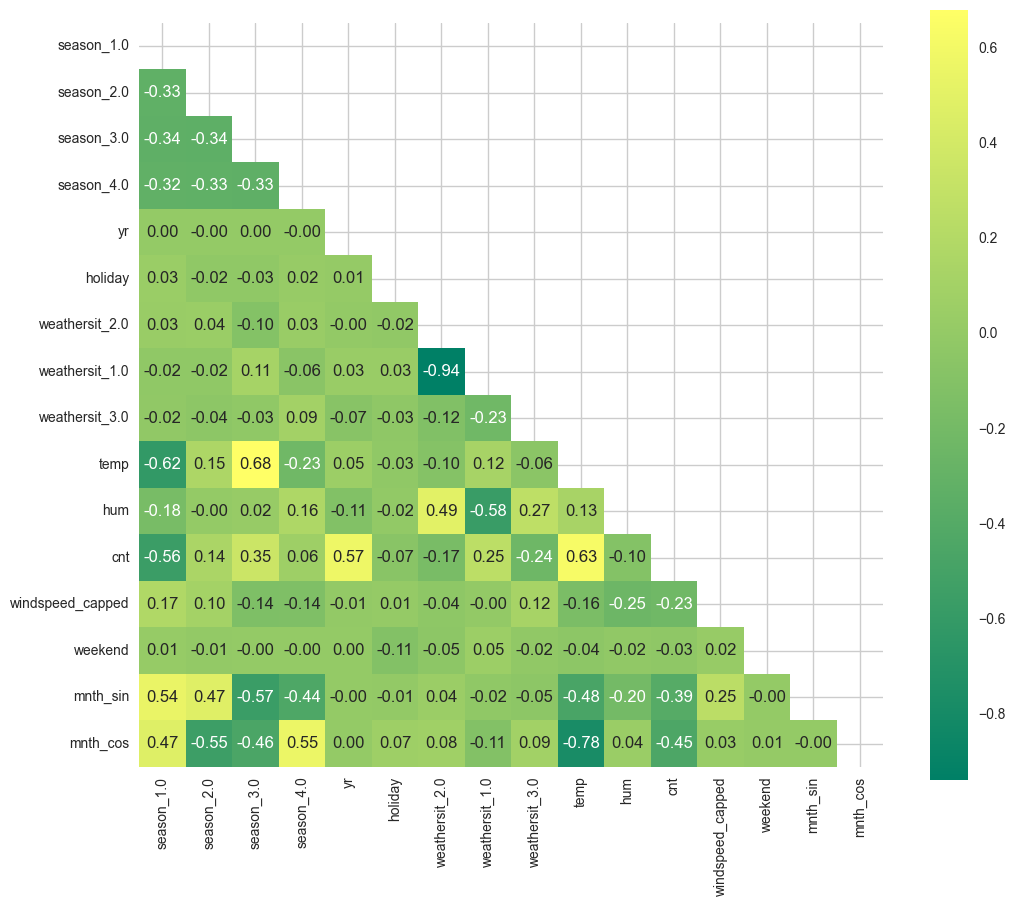

In [46]:
# Visualize the correlation matrix as a heatmap to easily identify relationships between the new variables

correlation_matrix = X.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", mask=mask, cmap="summer", cbar=True, square=True)

plt.show()

In [47]:
# Create the target
y = X['cnt']

In [48]:
# Drop the target variable since we want to predict it
X = X.drop(columns=['cnt'])

# Modeling

## Random Forest

In [49]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state = 333)
# Clean sets to avoid future warning messages
y_train = y_train.values.ravel() 
y_test = y_test.values.ravel()

In [50]:
# Initialize the model
rf = RandomForestRegressor(random_state=12345, max_depth=3, min_samples_leaf=10)
rf

RandomForestRegressor(max_depth=3, min_samples_leaf=10, random_state=12345)

In [51]:
# Setting the seed for reproducibility
np.random.seed(12)

# Starting the timer
start = time.time()

# Defining the hyperparameter space for Random Forest

param_dist = {'max_depth': [3, 4, 5],
              'bootstrap': [True, False],
              'max_features': ['sqrt', 'log2'],
              'n_estimators': [100, 150, 200]
             }

# Initializing RandomizedSearchCV with Random Forest model (rf)
cv_randomForest = RandomizedSearchCV(rf, cv=10,
                                     param_distributions=param_dist,
                                     n_iter=10)  # Number of parameter settings that are sampled

# Fitting the RandomizedSearchCV to the training data
cv_randomForest.fit(X_train, y_train)

# Printing the best parameters found by RandomizedSearchCV
print('Best Parameters using random search: \n',
      cv_randomForest.best_params_)

# Ending the timer
end = time.time()

# Printing the time taken for the random search
print('Time taken in random search: {0: .2f}'.format(end - start))

Best Parameters using random search: 
 {'n_estimators': 100, 'max_features': 'log2', 'max_depth': 5, 'bootstrap': False}
Time taken in random search:  12.74


In [52]:
best_params = cv_randomForest.best_params_

# Set the Random Forest model parameters to the best parameters found
rf.set_params(**best_params)

RandomForestRegressor(bootstrap=False, max_depth=5, max_features='log2',
                      min_samples_leaf=10, random_state=12345)

In [53]:
# Fit the Random Forest model to the training data
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=5, max_features='log2',
                      min_samples_leaf=10, random_state=12345)

In [54]:
# Use the trained Random Forest model to make predictions on the training and test data
rf_predictions_train = rf.predict(X_train)
rf_predictions_test = rf.predict(X_test)

# Calculate the absolute errors between predicted and actual values
rf_errors = abs(rf_predictions_test - y_test)

# Print the mean absolute error (MAE) to evaluate model performance
print('Mean Absolute Error:', round(np.mean(rf_errors), 2), 'degrees')

# Calculate the R2 score to assess the goodness of fit of the model
r2 = r2_score(y_test, rf_predictions_test)

# Print the R2 score to evaluate model performance
print('R2 Score:', round(r2, 2))

# Calculate the Root Mean Squared Error (RMSE) to evaluate model performance
rmse_rf = sqrt(mean_squared_error(y_test, rf_predictions_test))

# Print the RMSE to evaluate model performance
print('RMSE:', round(rmse_rf, 2))

Mean Absolute Error: 659.83 degrees
R2 Score: 0.81
RMSE: 852.01


temp                0.275696
yr                  0.267947
season_1.0          0.148533
mnth_cos            0.067237
mnth_sin            0.063371
hum                 0.037246
season_3.0          0.029644
weathersit_1.0      0.029589
windspeed_capped    0.021812
season_4.0          0.019720
dtype: float64


<Axes: >

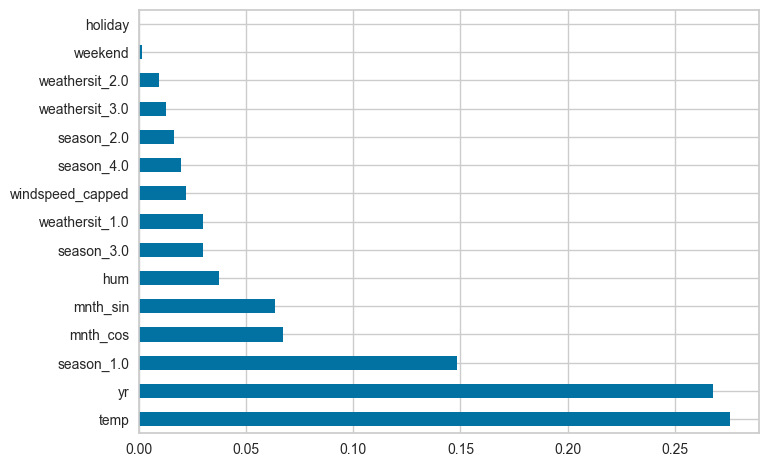

In [55]:
# Calculate feature importances and creating a series
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns)

# Sort the features by their importances
feature_importance = feature_importance.sort_values(ascending=False)
# Display the top 10 important features
print(feature_importance.head(10))
# Plot feature importances as a horizontal bar plot
feature_importance.plot(kind='barh')

In [56]:
# Select the top 6 important features
selected_features = feature_importance.head(6).index.tolist()

# Select the top 6 important features from the original dataset
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
print(feature_importance.head(6))

temp          0.275696
yr            0.267947
season_1.0    0.148533
mnth_cos      0.067237
mnth_sin      0.063371
hum           0.037246
dtype: float64


In [57]:
# Initialize the model with the selected features
rf_selected = RandomForestRegressor(random_state=12345)

# Fit the model with the selected features
rf_selected.fit(X_train_selected, y_train)

# Use the trained model to make predictions on the training and test data
rf_predictions_train_selected = rf_selected.predict(X_train_selected)
rf_predictions_test_selected = rf_selected.predict(X_test_selected)

# Calculate the absolute errors between predicted and actual values
rf_errors_selected = abs(rf_predictions_test_selected - y_test)

# Print the mean absolute error (MAE) to evaluate model performance
print('Mean Absolute Error (selected features):', round(np.mean(rf_errors_selected), 2), 'degrees')

# Calculate the R2 score to assess the goodness of fit of the model
r2_selected = r2_score(y_test, rf_predictions_test_selected)

# Print the R2 score to evaluate model performance
print('R2 Score (selected features):', round(r2_selected, 2))

# Calculate the Root Mean Squared Error (RMSE) to evaluate model performance
rmse_rf_selected = sqrt(mean_squared_error(y_test, rf_predictions_test_selected))

# Print the RMSE to evaluate model performance
print('RMSE (selected features):', round(rmse_rf_selected, 2))

Mean Absolute Error (selected features): 491.67 degrees
R2 Score (selected features): 0.87
RMSE (selected features): 698.83


<Axes: >

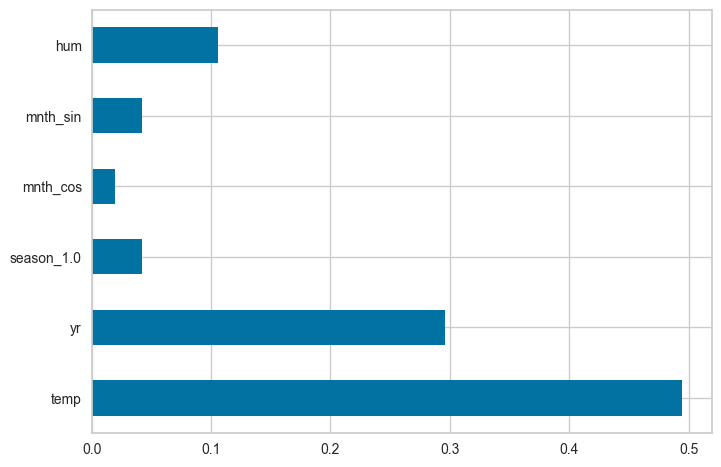

In [58]:
# Calculate feature importances for the selected features
feature_importance_selected = pd.Series(rf_selected.feature_importances_, index=selected_features)

# Plot feature importances as a horizontal bar plot
feature_importance_selected.plot(kind='barh')

# Evaluation

In [59]:
# Predict y for X_train and X_test using the selected features

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
rf_selected = RandomForestRegressor(random_state=12345)
rf_selected.fit(X_train_selected, y_train)
y_pred_train_selected = rf_selected.predict(X_train_selected)
y_pred_test_selected = rf_selected.predict(X_test_selected)

In [60]:
# Create a dataframe with metrics

def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
    measures_list = ['MAE', 'RMSE', 'R^2', 'MAPE (%)', 'MAX Error']
    train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                     np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                     metricsObj.r2_score(yTrain, yPredTrain),
                     metricsObj.mean_absolute_percentage_error(yTrain, yPredTrain),
                     metricsObj.max_error(yTrain, yPredTrain)]
    test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                    np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                    metricsObj.r2_score(yTest, yPredTest),
                    metricsObj.mean_absolute_percentage_error(yTest, yPredTest),
                    metricsObj.max_error(yTest, yPredTest)]
    resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test': test_results})
    return resultsDF

In [61]:
#Show performance results using the selected features
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train_selected, y_test, y_pred_test_selected)
print(resultsDF)

     Measure        Train         Test
0        MAE   188.225792   491.673060
1       RMSE   277.859413   698.831509
2        R^2     0.979557     0.869311
3   MAPE (%)     0.218036     0.156367
4  MAX Error  1861.390000  2469.920000


In [62]:
# Visualize predictions vs target values 

# Convert y_test to a pandas DataFrame
temp = pd.DataFrame(y_test, columns=['Target'])

temp['Prediction'] = y_pred_test_selected
temp['Residual'] = temp['Target'] - temp['Prediction']
print(temp)

     Target  Prediction  Residual
0       986     1159.48   -173.48
1      4891     5096.81   -205.81
2      6569     6929.46   -360.46
3      2121     2125.12     -4.12
4      6660     6646.49     13.51
..      ...         ...       ...
178    5008     4235.35    772.65
179    3811     3138.90    672.10
180    4023     3890.94    132.06
181    5191     3745.27   1445.73
182    2169     2125.76     43.24

[183 rows x 3 columns]


Text(0, 0.5, 'y_pred')

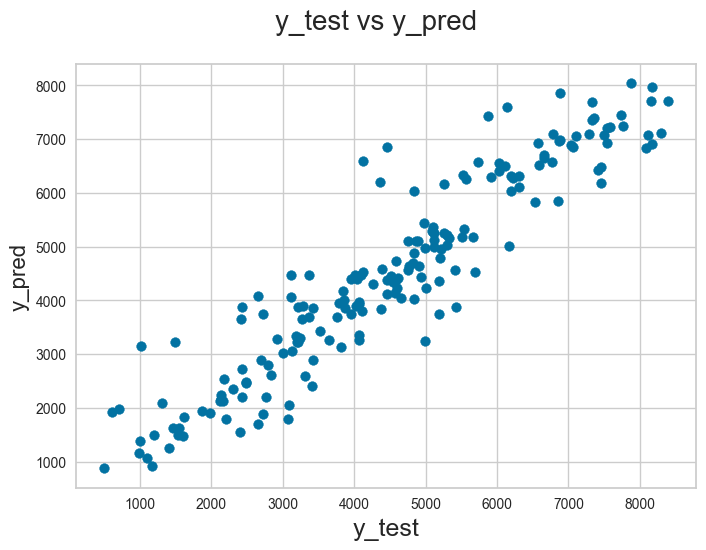

In [63]:
# Plot of actual vs. predicted target values

fig = plt.figure()
plt.scatter(y_test, y_pred_test_selected)
fig.suptitle('y_test vs y_pred', fontsize = 20)               
plt.xlabel('y_test', fontsize = 18)                          
plt.ylabel('y_pred', fontsize = 16)

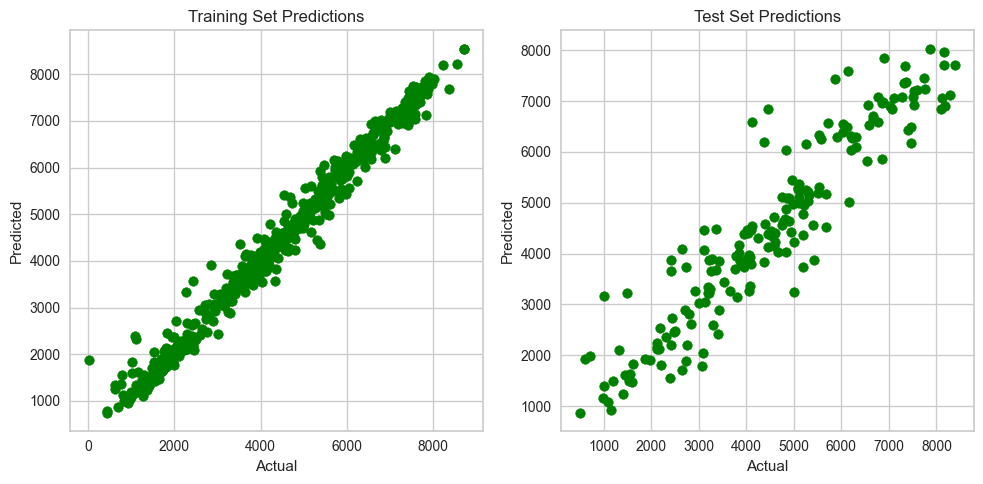

In [64]:
# Plot actual vs. predicted target values for both training and test sets

plt.figure(figsize=(10, 5))

# Training set plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train_selected, color='green')
plt.title('Training Set Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

# Test set plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test_selected, color='green')
plt.title('Test Set Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()

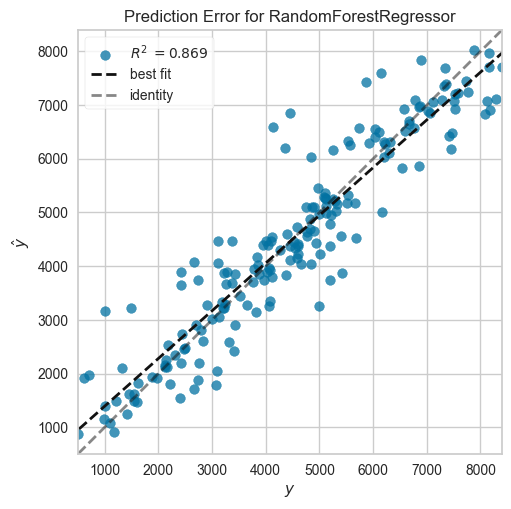

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [65]:
# Visualize the prediction error

predError_vis = PredictionError(rf_selected)
predError_vis.fit(X_train_selected, y_train)  # Fit the training data to the visualizer
predError_vis.score(X_test_selected, y_test)  # Evaluate the model on the test data
predError_vis.show()

Text(0.5, 0, 'Errors')

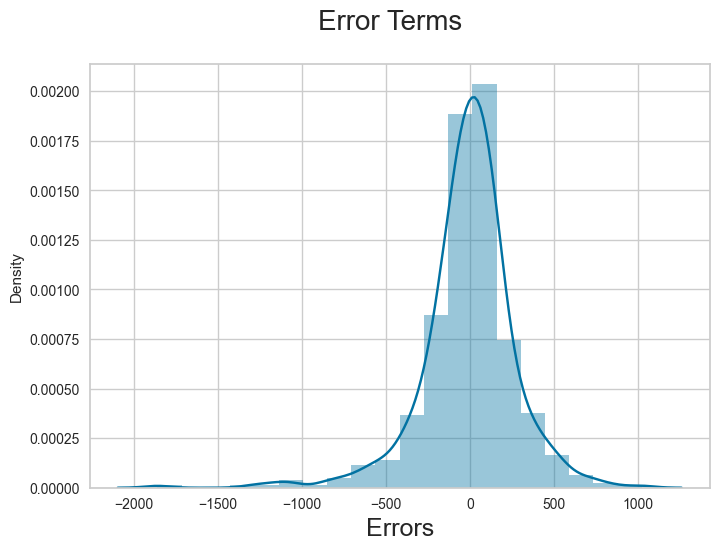

In [66]:
# Plot the histogram of the error terms

fig = plt.figure()
sns.distplot((y_train - y_pred_train_selected), bins=20)
fig.suptitle('Error Terms', fontsize=20)
plt.xlabel('Errors', fontsize=18)

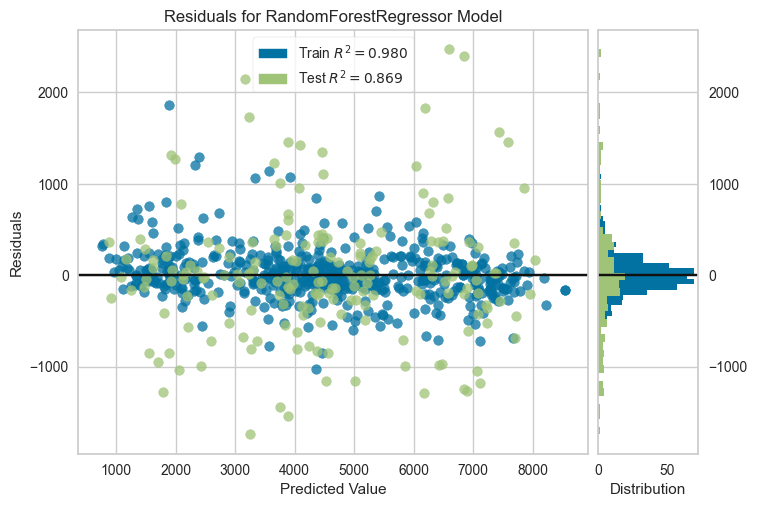

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [67]:
# Visualize the residuals

residuals_vis = ResidualsPlot(rf_selected)
residuals_vis.fit(X_train_selected, y_train)  # Fit the training data to the visualizer
residuals_vis.score(X_test_selected, y_test)  # Evaluate the model on the test data
residuals_vis.show()

# Deployment

In [68]:
# Load the trained model

with open("model.pickle", "wb") as file:
    pickle.dump(rf, file)

In [69]:
# Run predictions
y_pred = rf.predict(X)

In [70]:
# Show predictions
X['cnt'] = y_pred
X

,season_1.0,season_2.0,season_3.0,season_4.0,yr,holiday,weathersit_2.0,weathersit_1.0,weathersit_3.0,temp,hum,windspeed_capped,weekend,mnth_sin,mnth_cos,cnt
0,1,0,0,0,0,0,1,0,0,0.344167,0.805833,0.160446,1,5.000000e-01,0.866025,1871.893592
1,1,0,0,0,0,0,1,0,0,0.363478,0.696087,0.248539,1,5.000000e-01,0.866025,1914.085651
2,1,0,0,0,0,0,0,1,0,0.196364,0.437273,0.248309,0,5.000000e-01,0.866025,1884.275936
3,1,0,0,0,0,0,0,1,0,0.200000,0.590435,0.160296,0,5.000000e-01,0.866025,1926.832085
4,1,0,0,0,0,0,0,1,0,0.226957,0.436957,0.186900,0,5.000000e-01,0.866025,1911.091031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,1,0,0,0,1,0,1,0,0,0.254167,0.652917,0.350133,0,-2.449294e-16,1.000000,2493.750934
728,1,0,0,0,1,0,1,0,0,0.253333,0.590000,0.155471,0,-2.449294e-16,1.000000,2928.278945
729,1,0,0,0,1,0,1,0,0,0.253333,0.752917,0.124383,1,-2.449294e-16,1.000000,2560.451900
730,1,0,0,0,1,0,0,1,0,0.255833,0.483333,0.350754,1,-2.449294e-16,1.000000,2664.257823


In [71]:
# Export results
X.to_excel("ResultsRandomForest.xlsx")

Upon analyzing the performance metrics of our Random Forest model, we observe a contrast between its performance on the training and test datasets. On the training set, the model showcases an excelent performance, with a low Mean Absolute Error (MAE), Root Mean Square Error (RMSE), and a high coefficient of determination (R²). However, this performance diminishes when the model is applied to test data.

In an attempt to mitigate the overfitting and improve the model's performance, we experimented with various techniques, including feature engineering. To delve deeper into the model's behavior, we examined feature importance. By selecting the top 6 important features, we aimed to understand which variables significantly influence the model's predictions. These selected features were then used to train both the training and test datasets. This approach allows us to focus on the most impactful features while potentially reducing noise and improving model performance. Regrettably, these efforts did not yield substantial improvements, indicating that the model may still suffer from overfitting.

Further refinement and optimization, particularly focusing on feature selection and regularization techniques, may be necessary to enhance the model's robustness and ensure better generalization to real-world scenarios.